In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import statistics as std
import seaborn as sns
import copy
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
import statsmodels.api as sm

# **1. Чтение файла**


In [2]:
df = pd.read_csv('taxi.csv', sep=',')
#'https://www.dropbox.com/s/dl/q7d6fxtpe8tp6g7/taxi.csv'
df

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2863541,2,2016-01-31 13:12:20,2016-01-31 13:21:37,2,-73.989609,40.741718,-73.991013,40.755867,N,557
1,id1752141,1,2016-05-03 18:20:59,2016-05-03 18:41:09,1,-73.993935,40.761517,-73.975281,40.751507,N,1210
2,id1331142,1,2016-06-05 02:20:39,2016-06-05 02:28:04,1,-73.988625,40.722538,-73.980347,40.742752,N,445
3,id0227018,2,2016-01-11 20:07:13,2016-01-11 20:14:26,1,-73.976723,40.775311,-73.964333,40.765560,N,433
4,id2263790,2,2016-01-22 00:31:59,2016-01-22 00:40:48,5,-74.005852,40.740360,-73.988708,40.758781,N,529
...,...,...,...,...,...,...,...,...,...,...,...
99995,id1085998,2,2016-05-10 17:09:15,2016-05-10 17:28:13,1,-73.990089,40.751648,-73.981262,40.784264,N,1138
99996,id1119642,1,2016-02-13 23:25:04,2016-02-13 23:32:14,1,-73.985161,40.774433,-73.976547,40.790916,N,430
99997,id3739873,2,2016-04-19 17:22:31,2016-04-19 17:43:12,1,-73.975052,40.756241,-73.984818,40.769341,N,1241
99998,id1863124,2,2016-06-22 20:50:36,2016-06-22 21:04:30,1,-73.983192,40.744656,-73.950607,40.783321,N,834


Отфильтруем дата сет по пездкам за выходыне.

In [3]:
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

In [4]:
df[df['dropoff_datetime'].dt.dayofweek>=5]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2863541,2,2016-01-31 13:12:20,2016-01-31 13:21:37,2,-73.989609,40.741718,-73.991013,40.755867,N,557
2,id1331142,1,2016-06-05 02:20:39,2016-06-05 02:28:04,1,-73.988625,40.722538,-73.980347,40.742752,N,445
5,id3105911,2,2016-03-12 11:45:30,2016-03-12 12:06:40,5,-73.989853,40.762321,-73.990356,40.719570,N,1270
6,id3638379,1,2016-02-27 19:24:57,2016-02-27 20:02:12,1,-73.981590,40.773579,-73.985977,40.726574,N,2235
9,id0280140,1,2016-04-09 23:33:12,2016-04-09 23:44:10,1,-73.989906,40.756668,-73.987427,40.768623,N,658
...,...,...,...,...,...,...,...,...,...,...,...
99988,id2622579,2,2016-03-06 14:12:16,2016-03-06 14:21:13,1,-73.988487,40.759212,-74.003883,40.747547,N,537
99990,id3919255,1,2016-04-10 10:14:43,2016-04-10 10:22:44,2,-73.961388,40.774467,-73.969559,40.760349,N,481
99992,id2189210,2,2016-01-23 05:36:06,2016-01-23 05:53:38,1,-73.996338,40.763706,-73.948715,40.815403,N,1052
99994,id0959872,2,2016-03-27 14:39:03,2016-03-27 14:43:05,6,-73.984451,40.768520,-73.973640,40.763699,N,242


Отфильтруем по месяцам.

In [5]:
df["month"]=pd.DatetimeIndex(df['dropoff_datetime']).month
df["month"].value_counts()

3    17648
4    17260
5    16931
6    16169
2    16090
1    15898
7        4
Name: month, dtype: int64

# **2. Создание df**

In [6]:
normal_distribution= np.random.normal(loc=1440, scale=200, size=1)
normal_distribution

array([1350.85913519])

In [7]:
df2 = copy.copy(pd.DataFrame(columns=('user_id', 'order_number', 'delivery_time','order_sum','retention','average_time','segment')))
normal_distribution= np.random.normal(loc=1440, scale=200, size=10000)
exp = np.random.exponential(1,10000)
for i in range(10000):
    df2.loc[i] = [''.join((random.choice('1234567890abcdefghigk') for i in range(15))),random.randint(1,10),normal_distribution[i],exp[i]+1,int(np.random.choice([1,2,3,4,5], p=[0.35,0.25,0.2,0.15,0.05])),0,'']

In [8]:
df2

,user_id,order_number,delivery_time,order_sum,retention,average_time,segment
0,d70ge7ic8d7bghk,4,1517.511920,2.835897,2,0,
1,525dd2eehhfhk39,5,1343.781840,1.113283,2,0,
2,824gbfdkf3ff0h2,2,1352.229250,1.870426,3,0,
3,0c5ag77e187dg5h,10,1564.066777,3.396311,4,0,
4,2ea1a1k375936de,8,1437.692583,2.512754,3,0,
...,...,...,...,...,...,...,...
9995,hge9e0ggg000c38,7,1634.184830,3.687987,1,0,
9996,g2bf45144giih7k,1,1076.073291,1.162488,1,0,
9997,5ec4hihheg293fg,2,1400.932347,2.920264,2,0,
9998,65kehck4fh4d850,7,1143.421581,3.457138,2,0,


# **Проверка**

In [9]:
df2.isnull().mean() * 100

user_id          0.0
order_number     0.0
delivery_time    0.0
order_sum        0.0
retention        0.0
average_time     0.0
segment          0.0
dtype: float64

In [10]:
df2.user_id.duplicated

<bound method Series.duplicated of 0       d70ge7ic8d7bghk
1       525dd2eehhfhk39
2       824gbfdkf3ff0h2
3       0c5ag77e187dg5h
4       2ea1a1k375936de
             ...       
9995    hge9e0ggg000c38
9996    g2bf45144giih7k
9997    5ec4hihheg293fg
9998    65kehck4fh4d850
9999    6gc58c2e96dh0f5
Name: user_id, Length: 10000, dtype: object>

Дубликаты отсутсвуют

In [11]:
df2.groupby("order_number").agg("delivery_time").mean()

order_number
1     1445.940871
2     1441.633048
3     1445.418280
4     1451.089366
5     1435.290935
6     1440.437061
7     1455.403508
8     1431.114031
9     1448.727617
10    1447.254502
Name: delivery_time, dtype: float64

In [12]:
a=list(df2.groupby("order_number").agg("delivery_time").mean())

a

[1445.94087114546,
 1441.6330483842926,
 1445.41828021543,
 1451.0893661193363,
 1435.2909346302977,
 1440.4370613171502,
 1455.4035079644639,
 1431.1140308549318,
 1448.7276171984279,
 1447.254501824241]

In [13]:
df2["average_time"] = df2.apply(lambda x: a[x['order_number'] - 1], axis=1)

In [14]:
df2

,user_id,order_number,delivery_time,order_sum,retention,average_time,segment
0,d70ge7ic8d7bghk,4,1517.511920,2.835897,2,1451.089366,
1,525dd2eehhfhk39,5,1343.781840,1.113283,2,1435.290935,
2,824gbfdkf3ff0h2,2,1352.229250,1.870426,3,1441.633048,
3,0c5ag77e187dg5h,10,1564.066777,3.396311,4,1447.254502,
4,2ea1a1k375936de,8,1437.692583,2.512754,3,1431.114031,
...,...,...,...,...,...,...,...
9995,hge9e0ggg000c38,7,1634.184830,3.687987,1,1455.403508,
9996,g2bf45144giih7k,1,1076.073291,1.162488,1,1445.940871,
9997,5ec4hihheg293fg,2,1400.932347,2.920264,2,1441.633048,
9998,65kehck4fh4d850,7,1143.421581,3.457138,2,1455.403508,


Классифицируем намера заказов по их номеру.


In [15]:
for i in df2.index:
    if df2["order_number"][i] in [1,2,3]:
        df2["segment"][i] = '1-3'
    elif df2["order_number"][i] in [4,5,6]:
        df2["segment"][i] = '4-6'
    elif df2["order_number"][i] in [7,8,9]:
        df2["segment"][i] = '7-9'
    else:
        df2["segment"][i] = '10'

/var/folders/9v/5p5m1vyn1l15r6g0mn4h76wc0000gn/T/ipykernel_14213/902466111.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["segment"][i] = '4-6'
/var/folders/9v/5p5m1vyn1l15r6g0mn4h76wc0000gn/T/ipykernel_14213/902466111.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["segment"][i] = '1-3'
/var/folders/9v/5p5m1vyn1l15r6g0mn4h76wc0000gn/T/ipykernel_14213/902466111.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["s

In [16]:
df2

,user_id,order_number,delivery_time,order_sum,retention,average_time,segment
0,d70ge7ic8d7bghk,4,1517.511920,2.835897,2,1451.089366,4-6
1,525dd2eehhfhk39,5,1343.781840,1.113283,2,1435.290935,4-6
2,824gbfdkf3ff0h2,2,1352.229250,1.870426,3,1441.633048,1-3
3,0c5ag77e187dg5h,10,1564.066777,3.396311,4,1447.254502,10
4,2ea1a1k375936de,8,1437.692583,2.512754,3,1431.114031,7-9
...,...,...,...,...,...,...,...
9995,hge9e0ggg000c38,7,1634.184830,3.687987,1,1455.403508,7-9
9996,g2bf45144giih7k,1,1076.073291,1.162488,1,1445.940871,1-3
9997,5ec4hihheg293fg,2,1400.932347,2.920264,2,1441.633048,1-3
9998,65kehck4fh4d850,7,1143.421581,3.457138,2,1455.403508,7-9


# **4. Исследование df**

1. Найдем моду для суммы стоимости заказа.

In [17]:
df2["order_sum"].mode()[0]

1.0000469634925917

Медиана:

In [18]:
df2["order_sum"].median()

1.6931752559761195

Среднее:

In [19]:
df2["order_sum"].mean()

2.0020381226830932

Дисперсия

In [20]:
df2["order_sum"].var()

1.0004655672708824

Ср.кв откл

In [21]:
df2["order_sum"].std()

1.0002327565476359

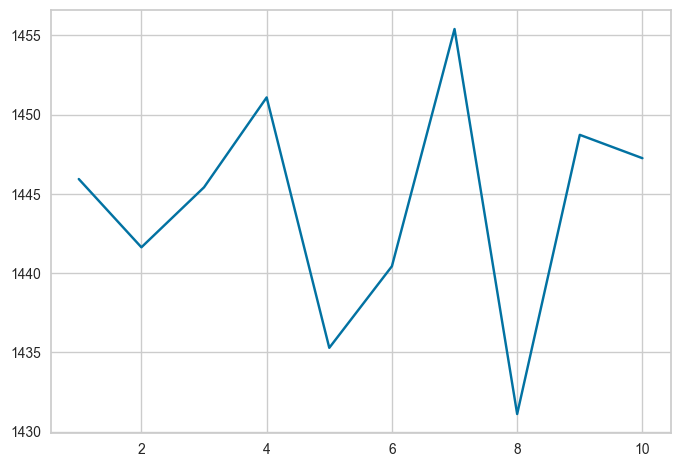

In [22]:
df3 = df2.groupby('order_number')["delivery_time"].mean().reset_index()
plt.plot(df3["order_number"],df3["delivery_time"])

In [23]:
df2

,user_id,order_number,delivery_time,order_sum,retention,average_time,segment
0,d70ge7ic8d7bghk,4,1517.511920,2.835897,2,1451.089366,4-6
1,525dd2eehhfhk39,5,1343.781840,1.113283,2,1435.290935,4-6
2,824gbfdkf3ff0h2,2,1352.229250,1.870426,3,1441.633048,1-3
3,0c5ag77e187dg5h,10,1564.066777,3.396311,4,1447.254502,10
4,2ea1a1k375936de,8,1437.692583,2.512754,3,1431.114031,7-9
...,...,...,...,...,...,...,...
9995,hge9e0ggg000c38,7,1634.184830,3.687987,1,1455.403508,7-9
9996,g2bf45144giih7k,1,1076.073291,1.162488,1,1445.940871,1-3
9997,5ec4hihheg293fg,2,1400.932347,2.920264,2,1441.633048,1-3
9998,65kehck4fh4d850,7,1143.421581,3.457138,2,1455.403508,7-9


In [24]:
df2[df2['order_number']==2]['delivery_time'].max()

2189.268523466289

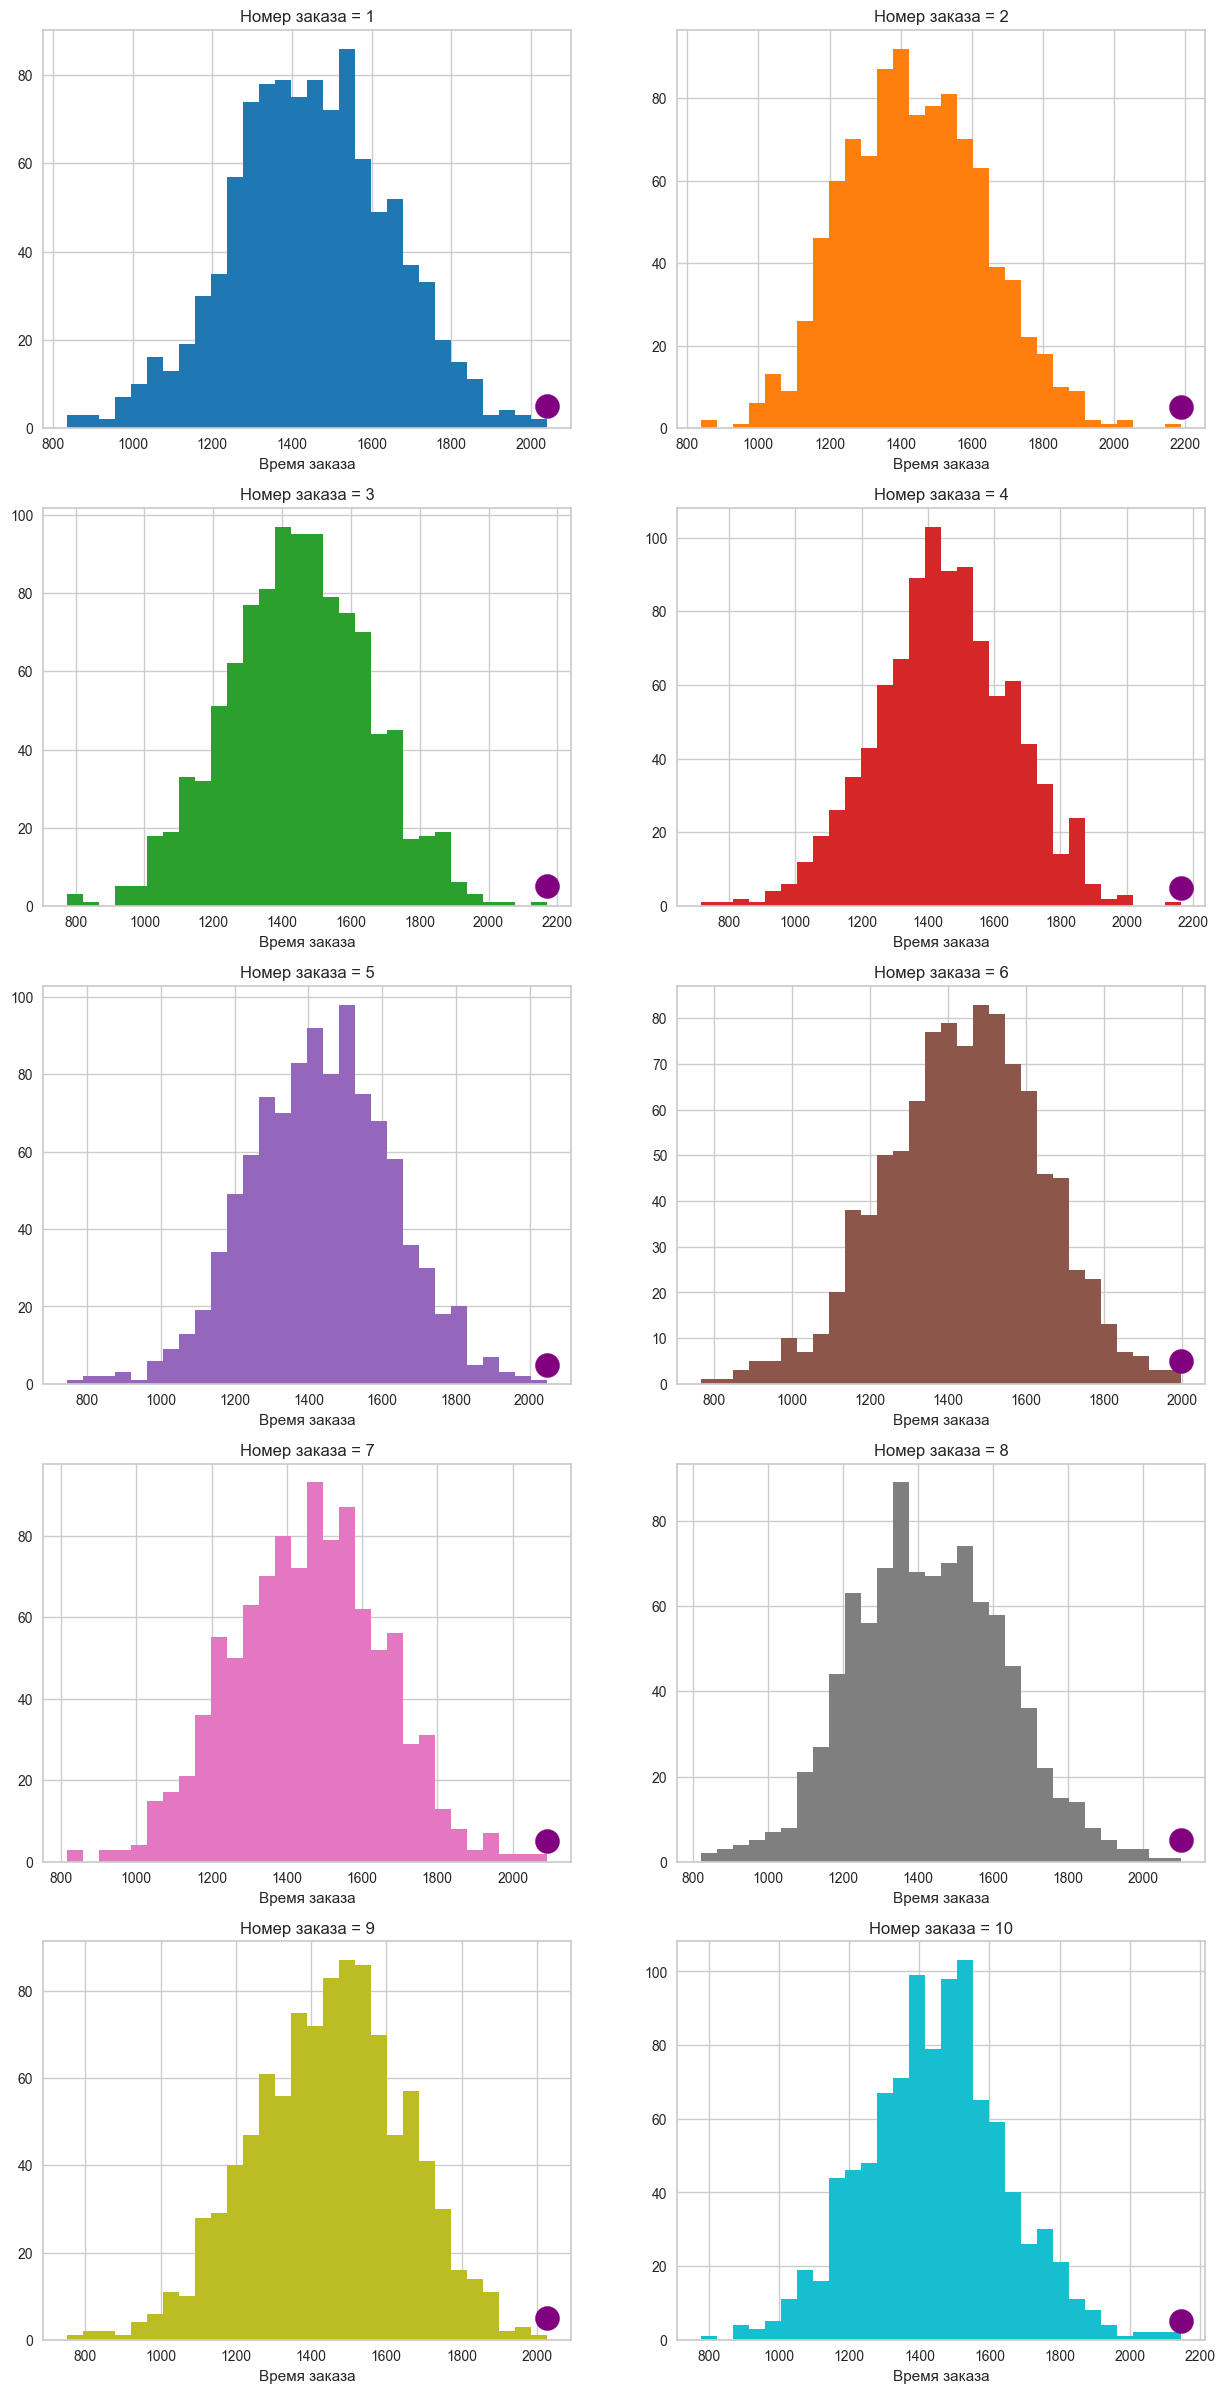

In [25]:
plt.rcParams["figure.figsize"] = (15,30)
fig, axs = plt.subplots(5,2)
num=1
colors = ['tab:blue',
'tab:orange',
'tab:green',
'tab:red',
'tab:purple',
'tab:brown',
'tab:pink',
'tab:gray',
'tab:olive',
'tab:cyan']
c=0
for i in range(5):
    axs[i,0].hist(df2[df2['order_number']==num]['delivery_time'],bins=30,color =colors[c])
    #plt.scatter(x[int(df2[df2['order_number']==num]['delivery_time'].max())], y[100], color='orange', s=500, marker='o')
    axs[i,0].scatter(int(df2[df2['order_number']==num]['delivery_time'].max()),5,s=300,color='purple')
    axs[i,0].set_title(f'Номер заказа = {num}')
    
    axs[i, 1].hist(df2[df2['order_number']==num+1]['delivery_time'],bins=30,color = colors[c+1])
    axs[i,1].set_title(f'Номер заказа = {num+1}')
    axs[i,1].scatter(int(df2[df2['order_number']==num+1]['delivery_time'].max()),5,s=300,color='purple')
    num+=2
    c+=2

for ax in axs.flat:
    ax.set( xlabel='Время заказа')
    




# Задание 5

# K-means

1. По методу локтя ищем требуемое количество кластеров.

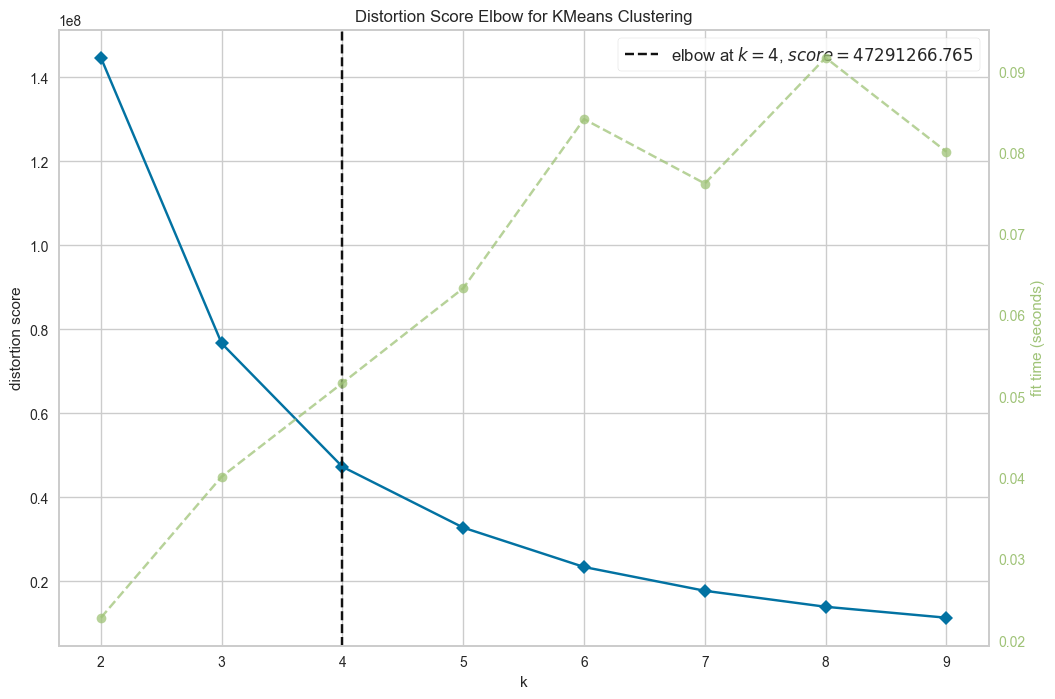

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [26]:
X = df2[["delivery_time", "order_sum"]]
kmeans = KMeans(n_clusters=4)  
kmeans.fit(X)
fig = plt.figure(figsize=(12,8))


model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(X)
visualizer.poof() 

Метод локтя по метрике Калински

/opt/homebrew/lib/python3.10/site-packages/yellowbrick/utils/kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/opt/homebrew/lib/python3.10/site-packages/yellowbrick/cluster/elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


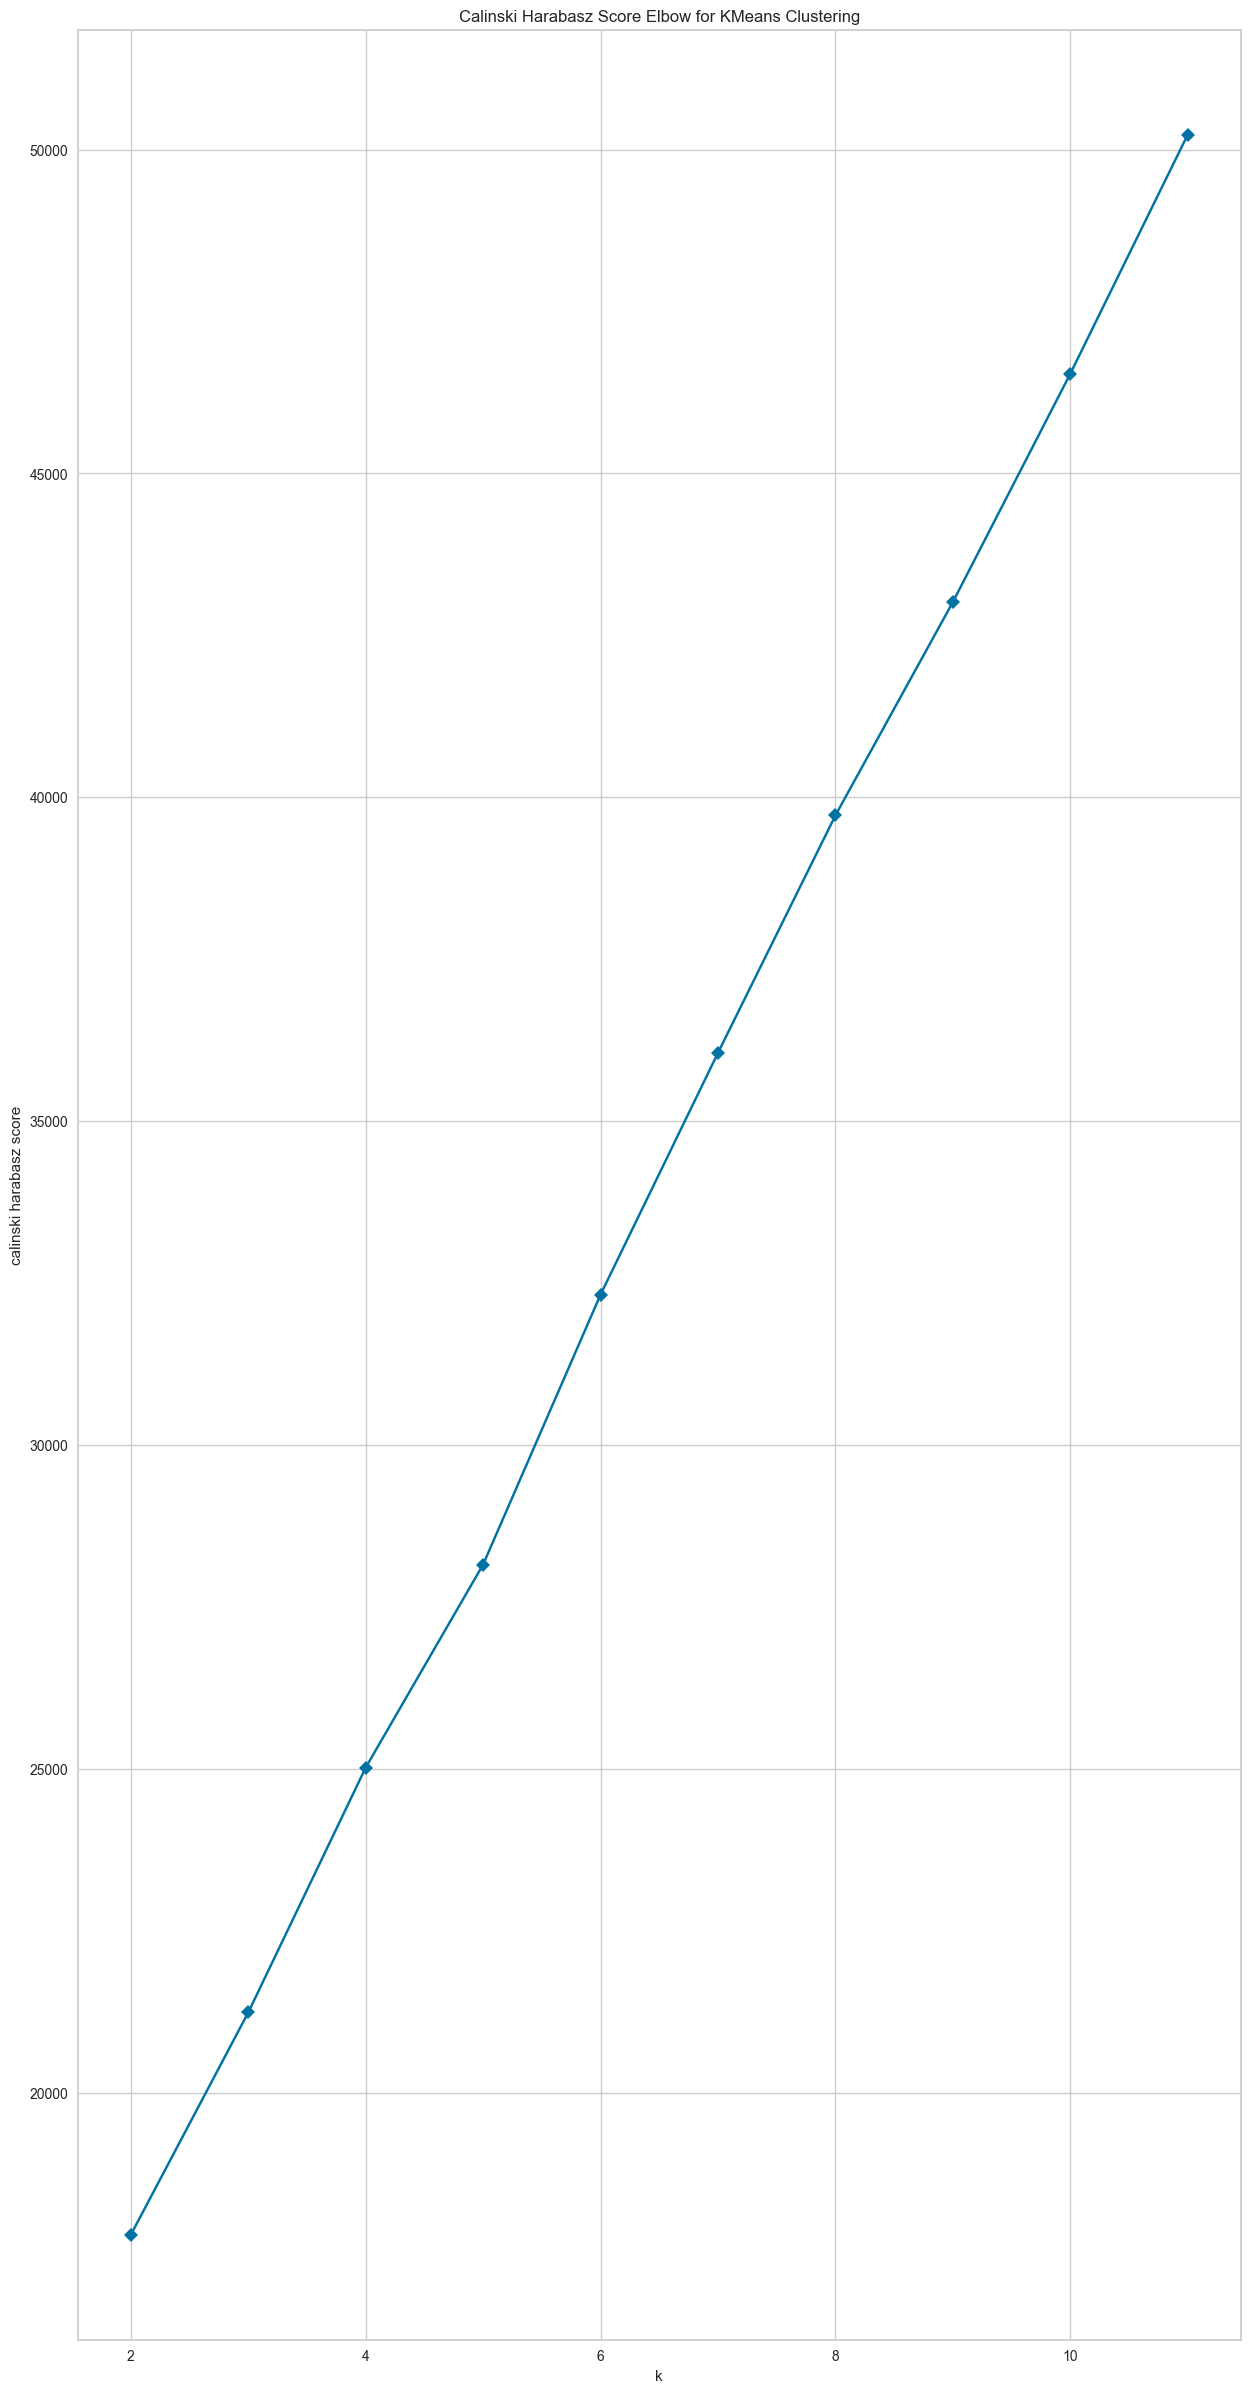

<AxesSubplot: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [27]:
visualizer = KElbowVisualizer(model, k=(2,12),metric = 'calinski_harabasz',timings = False)

visualizer.fit(X)
visualizer.poof() 

Метод Шатулет

In [28]:
range_n_clusters = list (range(2,7))
for n_clusters in range_n_clusters:
    clusterer1 = KMeans(n_clusters=n_clusters)
    preds1 = clusterer1.fit_predict(X)
    centers1 = clusterer1.cluster_centers_

    score1 = silhouette_score(X, preds1)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score1))

For n_clusters = 2, silhouette score is 0.5574481185691007)
For n_clusters = 3, silhouette score is 0.5285455572915569)
For n_clusters = 4, silhouette score is 0.5249350224699675)
For n_clusters = 5, silhouette score is 0.5172420916345614)
For n_clusters = 6, silhouette score is 0.5223128779891296)


In [29]:
print(kmeans.cluster_centers_)

[[1356.75660204    2.02664782]
 [1744.32531805    1.99431071]
 [1145.10021687    2.02102793]
 [1537.7294685     1.97111064]]


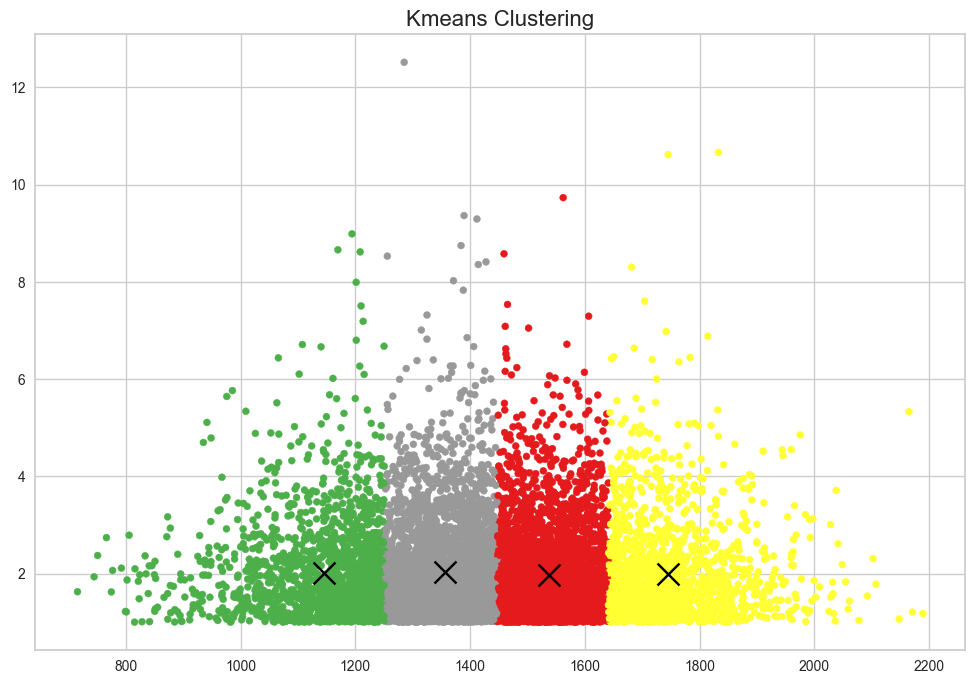

In [30]:
fig = plt.figure(figsize=(12,8))

plt.scatter(X.values[:,0], X.values[:,1], c=kmeans.labels_, cmap="Set1_r", s=25)
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black', marker="x", s=250) # центры кластеров
plt.title("Kmeans Clustering", fontsize=16)
plt.show()

In [31]:
df2['group'] = kmeans.predict(X)

In [32]:
df2

,user_id,order_number,delivery_time,order_sum,retention,average_time,segment,group
0,d70ge7ic8d7bghk,4,1517.511920,2.835897,2,1451.089366,4-6,3
1,525dd2eehhfhk39,5,1343.781840,1.113283,2,1435.290935,4-6,0
2,824gbfdkf3ff0h2,2,1352.229250,1.870426,3,1441.633048,1-3,0
3,0c5ag77e187dg5h,10,1564.066777,3.396311,4,1447.254502,10,3
4,2ea1a1k375936de,8,1437.692583,2.512754,3,1431.114031,7-9,0
...,...,...,...,...,...,...,...,...
9995,hge9e0ggg000c38,7,1634.184830,3.687987,1,1455.403508,7-9,3
9996,g2bf45144giih7k,1,1076.073291,1.162488,1,1445.940871,1-3,2
9997,5ec4hihheg293fg,2,1400.932347,2.920264,2,1441.633048,1-3,0
9998,65kehck4fh4d850,7,1143.421581,3.457138,2,1455.403508,7-9,2


# Задание 5

Выберем 2 любых кластера и сравним их. Например, 0 и 1

In [33]:
df_ab=pd.DataFrame({'statistic':['std','min','max','mean','var','median'],'group_0':[df2[df2['group']==0]['delivery_time'].std(),df2[df2['group']==0]['delivery_time'].min(),df2[df2['group']==0]['delivery_time'].max(),df2[df2['group']==0]['delivery_time'].mean(),df2[df2['group']==0]['delivery_time'].var(),df2[df2['group']==0]['delivery_time'].median()]})

In [34]:
df_ab['group_1'] = [df2[df2['group']==1]['delivery_time'].std(),df2[df2['group']==1]['delivery_time'].min(),df2[df2['group']==1]['delivery_time'].max(),df2[df2['group']==1]['delivery_time'].mean(),df2[df2['group']==1]['delivery_time'].var(),df2[df2['group']==1]['delivery_time'].median()]

In [35]:
df_ab

,statistic,group_0,group_1
0,std,55.444523,88.152052
1,min,1251.115953,1641.119158
2,max,1447.100428,2189.268523
3,mean,1356.292377,1744.262693
4,var,3074.095177,7770.784185
5,median,1360.273017,1721.167325


In [40]:
df_ab['group_0'][3]

1356.2923772380343

In [70]:
z ,pvalue  = sm.stats.proportions_ztest([df_ab['group_0'][3],df_ab['group_0'][4]],[df_ab['group_1'][3],df_ab['group_0'][4]])
z,pvalue

(-27.269716634564077, 9.701923625606536e-164)

За основу возьмём $\alpha = 0.05$, в таком случае, п-значение меньше уровня значимости,следовательно, гипотезу h0 = метрики выборок принадлежат одному и тому же кластеру мы отвергаем, слодовательно, значения выборок из каждых кластеров статистически значимо различаются. Это подтверждает теорию о том, что а и б принадлежат разным выборкам и что кластеризация прошла успешно. Разделив клиентов на кластеры, мы можем отчетливо понять разницу среднего врмени ожидания каждого клиента.